### Utils

In [46]:
import pandas as pd
import sqlite3 as sql
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_theme(context='notebook', style='white', font_scale=1.5)

matplotlib.rcParams['axes.linewidth'] = 1.5

# https://matplotlib.org/stable/users/explain/text/fonts.html
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
conn = sql.connect("../../research/fuzzing-ndss-2026/prelim/metrics.db")
# projects = list(pd.read_sql("select * from heartbeat", conn)['labels'].str.split(',', expand=True)[0].unique())
projects = [
    "js-yaml",
    "pako",
    "fast-xml-parser",
    # "angular",
    # "canvg",
    # "jimp",
    # "jpeg-js",
    # "lit",
    # "lodash",
    # "protobufjs",
    # "redux",
    # "sharp",
    # "tslib",
    # "turf",
    # "typescript",
    # "ua-parser-js",
    # "xml2js",
    # "xmldom",
]

In [6]:
def get_all_data(conn):
    df = pd.read_sql("select * from heartbeat", conn)

    # coverage percentage
    df['covpct'] = df['coverage'] * 100 / df['total_edges']
    df['valid_covpct'] = df['valid_coverage'] * 100 / df['total_edges']
    
    # split labels into columns
    df = df.join(df['labels'].str.split(",", expand=True).rename(columns={0: "project", 1: "mode", 2: "schema", 3: "driver", 4: "iter"}))
    df['iter'] = df['iter'].astype(int)
    
    # # TODO: take start times from fuzzer-config.json?
    # # adjust timestamps so they start from 0
    # start_times = { mode: [df[(df['iter'] == x) & (df['mode'] == mode)]['timestamp'].iloc[0] for x in range(iterations)] for mode in modes }
    # start_offsets = df.apply(lambda row: start_times[row['mode']][row['iter']], axis=1)
    # df['timestamp'] = df['timestamp'] - start_offsets
    
    df = df.drop(["labels", "valid_corpus", "corpus", "driver"], axis=1)
    return df

In [7]:
def get_project_data(project, conn):
    df = pd.read_sql(f"select * from heartbeat where labels like '{project}%'", conn)

    # coverage percentage
    df['covpct'] = df['coverage'] * 100 / df['total_edges']
    df['valid_covpct'] = df['valid_coverage'] * 100 / df['total_edges']
    
    # split labels into columns
    df = df.join(df['labels'].str.split(",", expand=True).rename(columns={0: "project", 1: "mode", 2: "schema", 3: "driver", 4: "iter"}))
    df['iter'] = df['iter'].astype(int)
    
    # # TODO: take start times from fuzzer-config.json?
    # # adjust timestamps so they start from 0
    # start_times = { mode: [df[(df['iter'] == x) & (df['mode'] == mode)]['timestamp'].iloc[0] for x in range(iterations)] for mode in modes }
    # start_offsets = df.apply(lambda row: start_times[row['mode']][row['iter']], axis=1)
    # df['timestamp'] = df['timestamp'] - start_offsets
    
    df = df.drop(["labels", "valid_corpus", "corpus", "driver"], axis=1)
    return df

# Coverage Over Time

In [49]:
ITERATIONS = 3

In [123]:
def coverage_df_for_schema(project, mode, schema, conn):
    df = get_project_data(project, conn)
    df = df[(df['schema'] == schema) & (df['mode'] == mode)]
    
    covs = []
    for i in [1, 2]:
        cov = df[df['iter'] == i].set_index('timestamp')['coverage']
        cov = cov.reset_index()
        cov['timestamp'] = cov['timestamp'] - cov['timestamp'].iloc[0]
        covs.append(cov.set_index('timestamp')['coverage'].rename(i))

    df = pd.concat(covs, axis=1).interpolate(method="nearest").reset_index()
    # df = pd.concat(covs, axis=1).reset_index()
    df['timestamp'] = df['timestamp'] - df['timestamp'].iloc[0]
    df = df.melt(id_vars="timestamp", var_name="iteration", value_name="edges")
    
    return df

def coverage_plot_for_schema(project, mode, schema, conn, label, linestyle):
    df = coverage_df_for_schema(project, mode, schema, conn)
    sns.lineplot(data=df, x="timestamp", y="edges", label=label, errorbar=("ci", 95), linewidth=2.2, linestyle=linestyle)

def coverage_plot(project, conn):
    # coverage_plot_for_schema(project, "bytes", "None", conn, "Driver", (0, (1, 2)))
    coverage_plot_for_schema(project, "sequence", "typescript", conn, "Annotated", (5, (10, 4)))
    coverage_plot_for_schema(project, "sequence", "None", conn, "Random", "-")

    plt.xlabel(None)
    plt.ylabel(None)
    # plt.xlabel("Time (s)")
    # plt.ylabel("# Edges")
    plt.xticks(fontsize=18, fontweight='roman')
    plt.yticks(fontsize=18, fontweight='roman')
    plt.ylim(bottom=0)
    plt.legend(prop={"size": 20, "weight": "roman"})
    plt.title(project)

    plt.savefig(f"./img/coverage-over-time-{project}.pdf")
    plt.show()

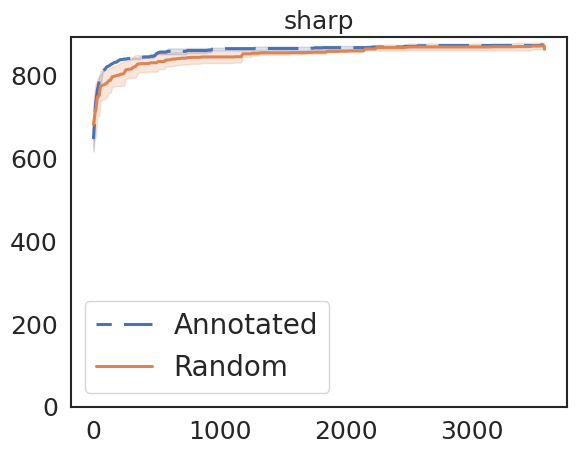

In [124]:
coverage_plot("sharp", conn)

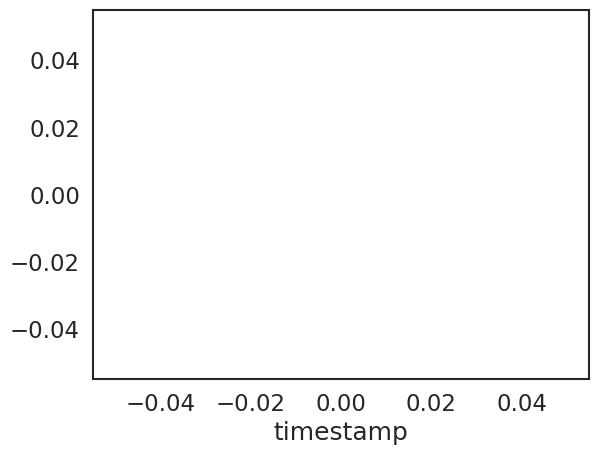

In [121]:
df = coverage_df_for_schema("sharp", "bytes", "None", conn)
df[df['iteration'] == 0].set_index('timestamp')['edges'].plot()
# df[df['iteration'] == 1].set_index('timestamp')['edges'].plot()
# df[df['iteration'] == 2].set_index('timestamp')['edges'].plot()
plt.show()

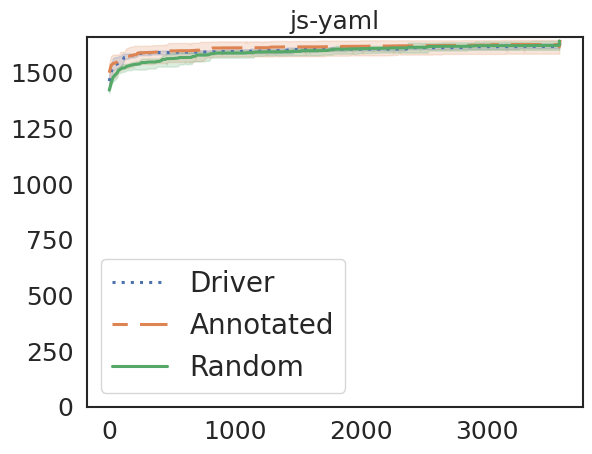

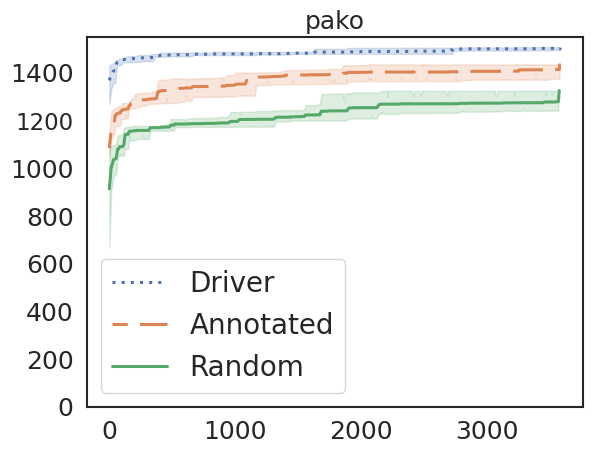

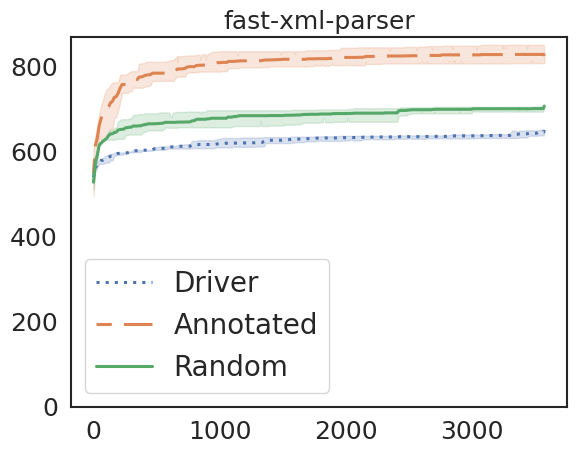

In [61]:
for project in projects:
    coverage_plot(project, conn)

# execs/s

In [42]:
df = get_all_data(conn)
df = df[df['project'].isin(projects)]

groups = df.groupby(['project', 'mode', 'schema', 'iter'])
start = groups.first()['timestamp']
end = groups.last()['timestamp']
execs = (groups.last()['execs'] / (end - start))

execs.groupby(level=['project', 'mode', 'schema']).mean()

project          mode      schema    
fast-xml-parser  bytes     None          3589.188728
                 sequence  None          3262.389499
                           typescript    1657.839860
js-yaml          bytes     None          5051.157023
                 sequence  None           402.372234
                           typescript     433.880494
pako             bytes     None           189.575751
                 sequence  None            30.275650
                           typescript      63.818812
dtype: float64

# Valid Coverage

In [44]:
df = get_all_data(conn)
df = df[df['project'].isin(projects)]
print(df.groupby(['project', 'mode', 'schema'])[['covpct', 'valid_covpct']].mean().loc[projects].to_latex())

\begin{tabular}{lllrr}
\toprule
 &  &  & covpct & valid_covpct \\
project & mode & schema &  &  \\
\midrule
\multirow[t]{3}{*}{js-yaml} & bytes & None & 74.040442 & 62.915756 \\
\cline{2-5}
 & \multirow[t]{2}{*}{sequence} & None & 74.015788 & 62.924227 \\
 &  & typescript & 74.830847 & 63.281032 \\
\cline{1-5} \cline{2-5}
\multirow[t]{3}{*}{pako} & bytes & None & 63.880854 & 58.433607 \\
\cline{2-5}
 & \multirow[t]{2}{*}{sequence} & None & 52.880397 & 43.056546 \\
 &  & typescript & 59.077025 & 49.658263 \\
\cline{1-5} \cline{2-5}
\multirow[t]{3}{*}{fast-xml-parser} & bytes & None & 50.594725 & 49.636745 \\
\cline{2-5}
 & \multirow[t]{2}{*}{sequence} & None & 55.371995 & 45.631343 \\
 &  & typescript & 65.364570 & 36.516312 \\
\cline{1-5} \cline{2-5}
\bottomrule
\end{tabular}



# Valid Executions

In [171]:
def execs(df):
    df = df.groupby(["project", "mode", "schema", "iter"]).last()[['execs', 'valid_execs']]
    df = (df['valid_execs'] * 100 / df['execs']).reset_index(level="iter")
    return df.groupby(["project", "mode", "schema"])[0].mean()

def get_with_adjusted_time(conn):
    df = get_all_data(conn)
    df = df[df['project'].isin(projects)]
    groups = df.groupby(["project", "mode", "schema", "iter"])
    df["start_time"] = groups['timestamp'].transform("first")
    df['adjusted_time'] = df['timestamp'] - df['start_time']
    return df

## Total Valid Executions

In [172]:
df = get_with_adjusted_time(conn)

In [173]:
execs(df)

project          mode      schema    
fast-xml-parser  bytes     None          54.880268
                 sequence  None          24.971057
                           typescript    22.799091
js-yaml          bytes     None          29.408146
                 sequence  None          53.532233
                           typescript    60.415017
pako             bytes     None          24.304933
                 sequence  None           0.044875
                           typescript     0.298703
Name: 0, dtype: float64

## First 10 Minutes

In [174]:
df = get_with_adjusted_time(conn)
execs(df[df['adjusted_time'] < 600])

project          mode      schema    
fast-xml-parser  bytes     None          54.552542
                 sequence  None          21.881708
                           typescript    23.404368
js-yaml          bytes     None          30.885945
                 sequence  None          52.542802
                           typescript    60.099056
pako             bytes     None          23.742750
                 sequence  None           0.027285
                           typescript     2.906919
Name: 0, dtype: float64

## Last 10 Minutes

In [194]:
df = get_with_adjusted_time(conn)
df = df[df['adjusted_time'] > 3000]

In [197]:
df[(df['project'] == 'pako') & (df['iter'] == 2) & (df['schema'] == 'typescript')]

,timestamp,objectives,execs,coverage,valid_execs,valid_coverage,total_edges,covpct,valid_covpct,project,mode,schema,iter,start_time,adjusted_time
8349,1765371161,176,199428,1412,3080,1299,2318,60.914582,56.039689,pako,sequence,typescript,2,1765368152,3009
8356,1765371177,176,200891,1412,3765,1299,2318,60.914582,56.039689,pako,sequence,typescript,2,1765368152,3025
8365,1765371196,176,201612,1412,4056,1299,2318,60.914582,56.039689,pako,sequence,typescript,2,1765368152,3044
8374,1765371215,176,202047,1412,4259,1299,2318,60.914582,56.039689,pako,sequence,typescript,2,1765368152,3063
8383,1765371232,177,202814,1412,4590,1299,2318,60.914582,56.039689,pako,sequence,typescript,2,1765368152,3080
8394,1765371254,177,203255,1412,162,1299,2318,60.914582,56.039689,pako,sequence,typescript,2,1765368152,3102
8401,1765371269,177,203630,1412,154,1299,2318,60.914582,56.039689,pako,sequence,typescript,2,1765368152,3117
8412,1765371293,177,204101,1412,125,1299,2318,60.914582,56.039689,pako,sequence,typescript,2,1765368152,3141
8420,1765371309,177,204731,1412,342,1299,2318,60.914582,56.039689,pako,sequence,typescript,2,1765368152,3157
8428,1765371325,177,205786,1412,850,1299,2318,60.914582,56.039689,pako,sequence,typescript,2,1765368152,3173


In [187]:
groups = df.groupby(["project", "mode", "schema", "iter"])
first = groups.first()
last = groups.last()
# df['valid_execs'] * 100 / df['execs']

In [193]:
diff = (last - first)
diff = (diff['valid_execs'] * 100 / diff['execs']).reset_index('iter')
diff[0].groupby(["project", "mode", "schema"]).mean()

project          mode      schema    
fast-xml-parser  bytes     None          54.765452
                 sequence  None          28.149692
                           typescript    22.175174
js-yaml          bytes     None          28.295876
                 sequence  None          54.037600
                           typescript    60.706048
pako             bytes     None          24.752132
                 sequence  None           0.048406
                           typescript    -2.917427
Name: 0, dtype: float64

In [189]:
last

timestamp  objectives     execs  \
project         mode     schema     iter                                     
fast-xml-parser bytes    None       0     1765378926           0  12258926   
                                    1     1765378925           0  12574091   
                                    2     1765378925           0  13642927   
                sequence None       0     1765357325         614  12770371   
                                    1     1765357321         480   9235119   
                                    2     1765357328         557  12964589   
                         typescript 0     1765368129         538   5538767   
                                    1     1765368124         567   5804168   
                                    2     1765368129         563   6439220   
js-yaml         bytes    None       0     1765386127           0  14301498   
                                    1     1765386134           0  12483471   
                                    2     1765386124           0  27382607   
                sequence None       0     1765364526         606    832457   
                                    1     1765364527         628   1998617   
                                    2     1765364525         660   1483305   
                         typescript 0     1765375333         721   1715167   
                                    1     1765375323         661   1945481   
                                    2     1765375326         524    993137   
pako            bytes    None       0     1765378934           0    469651   
                                    1     1765378929           0   1025155   
                                    2     1765382532           0    540640   
                sequence None       0     1765357324         223    133926   
                                    1     1765357322         263     84435   
                                    2     1765360932         274    105826   
                         typescript 0     1765368129         166    238164   
                                    1     1765368133         154    226118   
                                    2     1765371732         185    220676   

                                          coverage  valid_execs  \
project         mode     schema     iter                          
fast-xml-parser bytes    None       0          651      7174367   
                                    1          638      7048713   
                                    2          649      6829615   
                sequence None       0          703       914345   
                                    1          694      3622261   
                                    2          707      3698875   
                         typescript 0          808      1820223   
                                    1          851       636488   
                                    2          826      1581981   
js-yaml         bytes    None       0         1608      4239532   
                                    1         1630      3673643   
                                    2         1612      7982690   
                sequence None       0         1602       471406   
                                    1         1641       947291   
                                    2         1621       839122   
                         typescript 0         1646       971003   
                                    1         1645      1081704   
                                    2         1584       685577   
pako            bytes    None       0         1505       110453   
                                    1         1507       237500   
                                    2         1495       141807   
                sequence None       0         1269            4   
                                    1         1241           92   
                                    2         1325           24   
                         typescript 0 

In [167]:
execs(df[df['adjusted_time'] > 3000])

project          mode      schema    
fast-xml-parser  bytes     None          54.880268
                 sequence  None          24.971057
                           typescript    22.799091
js-yaml          bytes     None          29.408146
                 sequence  None          53.532233
                           typescript    60.415017
pako             bytes     None          24.304933
                 sequence  None           0.044875
                           typescript     0.298703
Name: 0, dtype: float64